## Imports

In [7]:
import numpy as np
import librosa as lr
import librosa.display as display
import madmom as mm
import matplotlib.pyplot as plt
import pretty_midi as pm

from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.optimizers import SGD

## Constants

In [8]:
DATAPOINT = "../datasets/maps/CH/" + \
            "MAPS_ISOL_CH0.1_F_SptkBGAm.wav"
MIDI_DATAPOINT = "../datasets/maps/CH/" + \
        "MAPS_ISOL_CH0.1_F_SptkBGAm.mid"
MIN_MIDI = 21
MAX_MIDI = 108

## Wrangle Datapoint

#### Transform:

In [9]:
log_spect = mm.audio.spectrogram.LogarithmicFilteredSpectrogram(
    DATAPOINT,
    num_bands=48,
    num_channels=1,
    sr=44100,
    unique_filters=True,
    norm_filters=True,
    frame_size=4096,
    fft_size=4096,
    fmin=27.5,
    fmax=8000.0,
    fref=440.0,
    circular_shift=False,
    fps=100,
    norm=True)

In [10]:
log_spect = lr.util.normalize(log_spect)
log_spect.shape

(2186, 229)

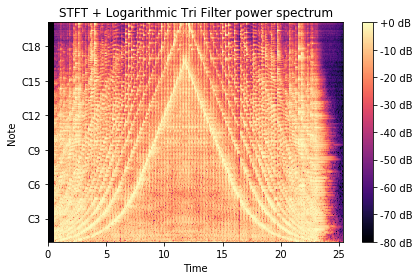

In [11]:
lr.display.specshow(
    lr.amplitude_to_db(log_spect, ref=np.max).T, 
    sr=44100,
    x_axis='time',
    y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT + Logarithmic Tri Filter power spectrum')
plt.tight_layout()

#### Ground truth:

In [13]:
times = lr.frames_to_time(
    np.arange(log_spect.shape[0]),
    sr=44100,
    hop_length=441.0)
midi = pm.PrettyMIDI(MIDI_DATAPOINT)
expected = midi.get_piano_roll(fs=44100, times=times)[MIN_MIDI:MAX_MIDI+1].T
expected[expected > 0] = 1

#### Visualize

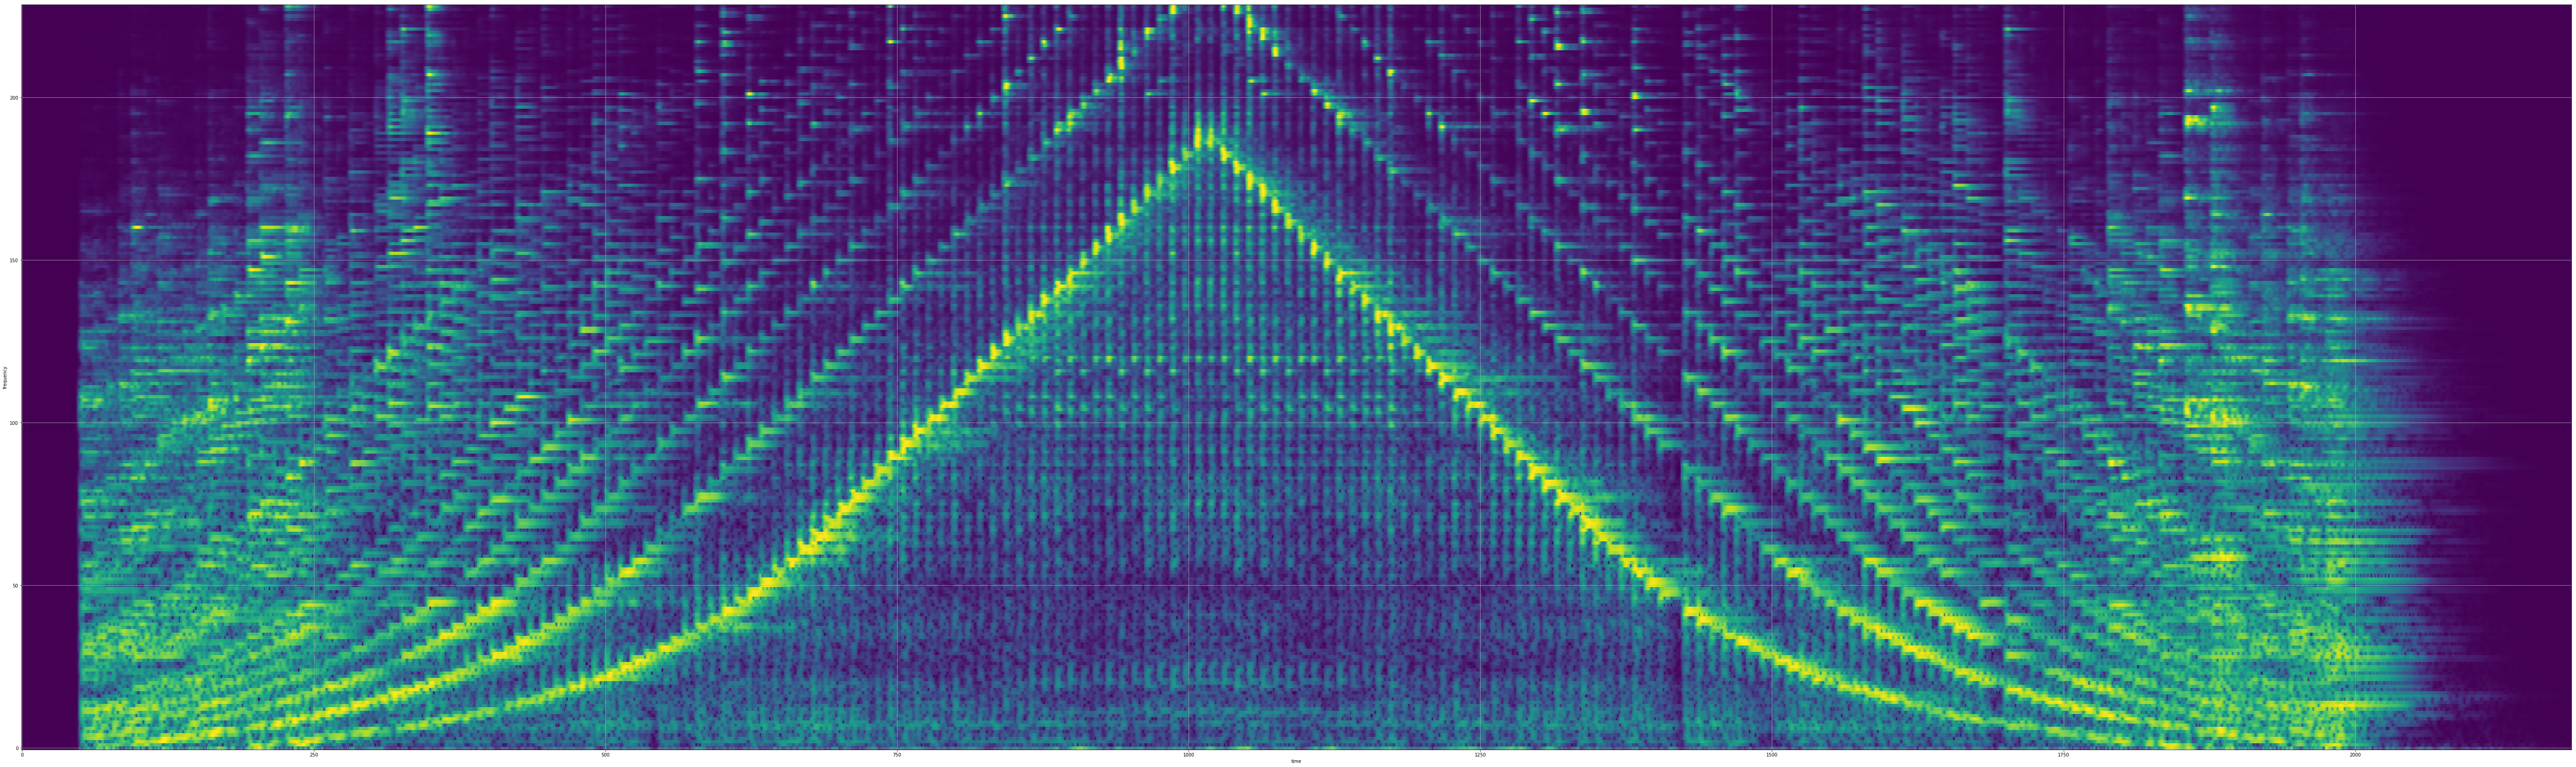

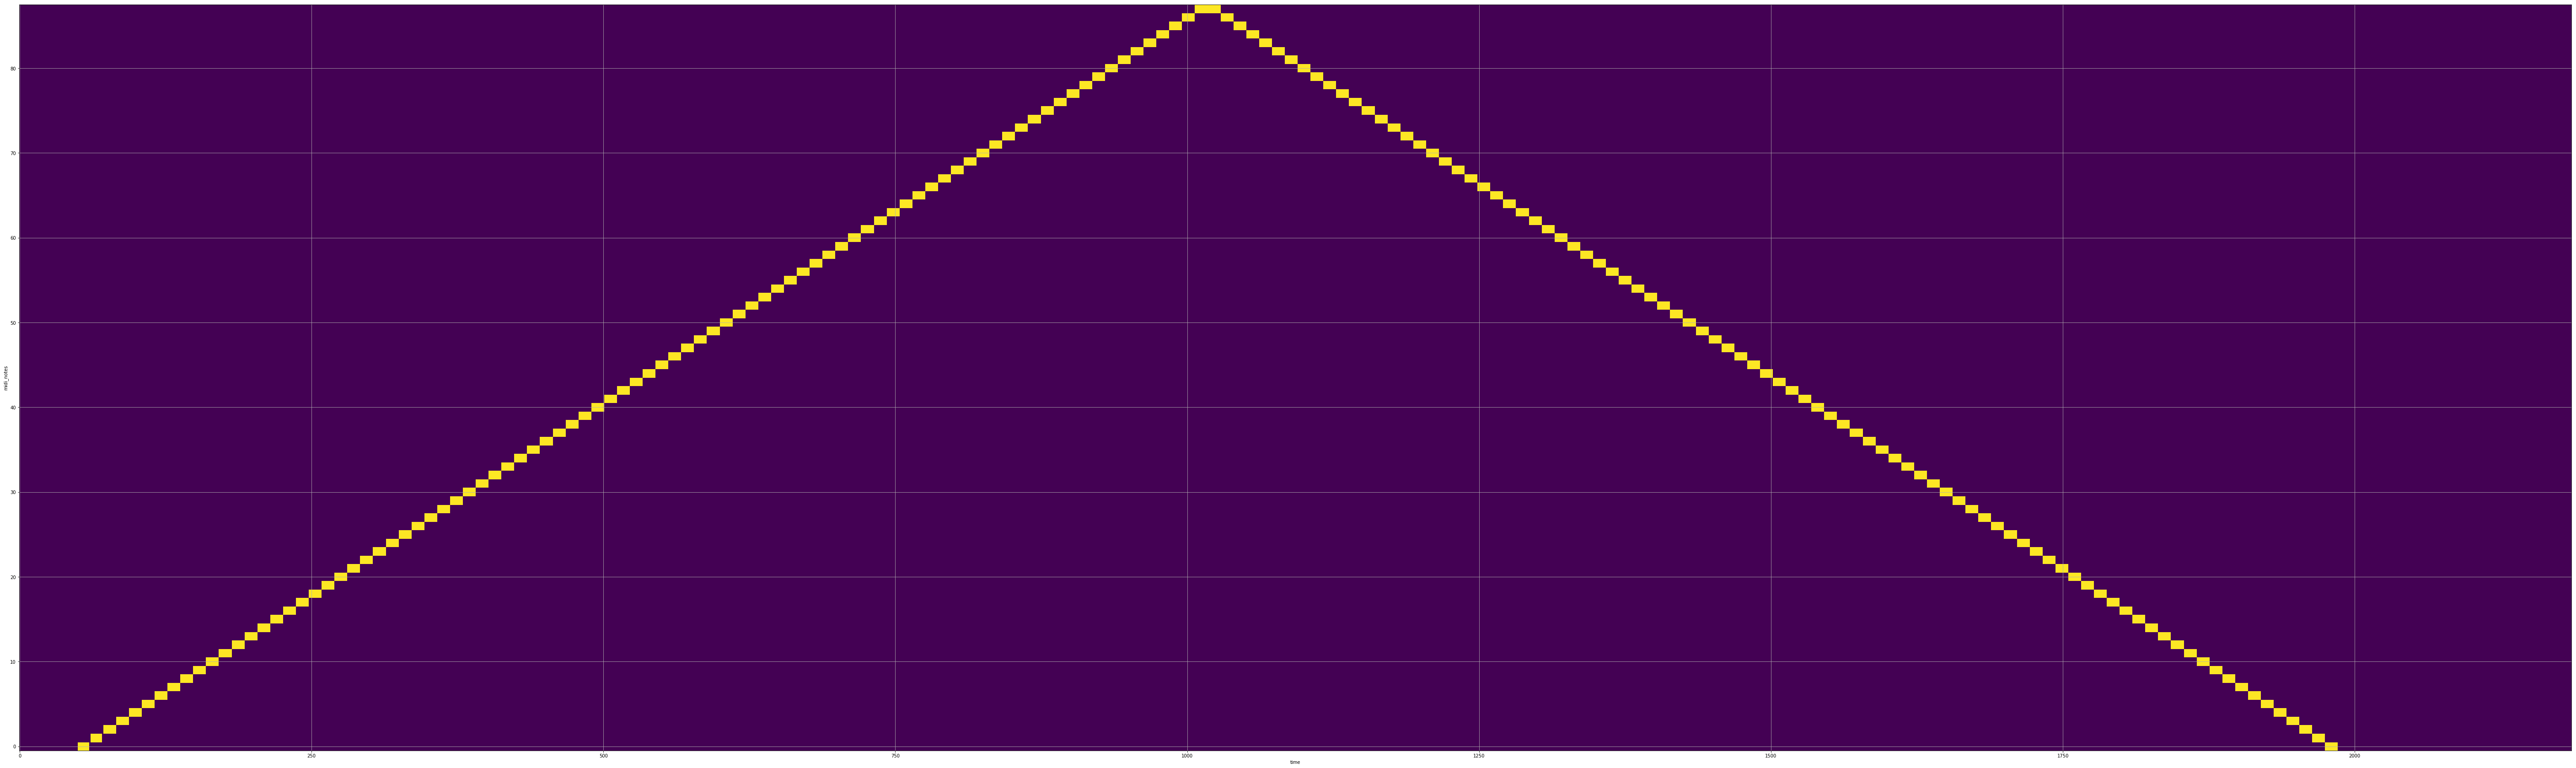

In [14]:
fig = plt.figure(figsize=(100,30))
plt.grid()
plt.imshow(log_spect.T,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('frequency')
plt.show()
fig = plt.figure(figsize=(100,30))
plt.grid()
plt.imshow(expected.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
plt.show()

## Compile Shallow Net

In [15]:
input_shape = (log_spect.shape[1],)
input_shape

(229,)

In [16]:
input = Input(input_shape)
hidden = Dense(512, input_dim=229, activation='relu')(input)
output = Dense(88, activation='sigmoid')(hidden)

shallow_net = Model(inputs=input, outputs=output)

In [17]:
shallow_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 229)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               117760    
_________________________________________________________________
dense_2 (Dense)              (None, 88)                45144     
Total params: 162,904
Trainable params: 162,904
Non-trainable params: 0
_________________________________________________________________


In [18]:
print log_spect.shape
print expected.shape

(2186, 229)
(2186, 88)


In [19]:
shallow_net.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=0.1, momentum=0.9),
    metrics=['accuracy', 'mse', 'mae'])

In [20]:
history = shallow_net.fit(
    x=log_spect,
    y=expected,
    batch_size=128,
    epochs=1000,
    verbose=1,
    validation_split=0.33)

Train on 1464 samples, validate on 722 samples
Epoch 1/1000
1464/1464 [==============================] - 1s 553us/step - loss: 0.5838 - acc: 0.7923 - mean_squared_error: 0.1971 - mean_absolute_error: 0.4362 - val_loss: 0.3638 - val_acc: 0.9917 - val_mean_squared_error: 0.0994 - val_mean_absolute_error: 0.2939
Epoch 2/1000
1464/1464 [==============================] - 0s 341us/step - loss: 0.1988 - acc: 0.9890 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1614 - val_loss: 0.1450 - val_acc: 0.9918 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.0957
Epoch 3/1000
1464/1464 [==============================] - 1s 351us/step - loss: 0.0871 - acc: 0.9890 - mean_squared_error: 0.0173 - mean_absolute_error: 0.0424 - val_loss: 0.1362 - val_acc: 0.9918 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.0739
Epoch 4/1000
1464/1464 [==============================] - 0s 326us/step - loss: 0.0868 - acc: 0.9890 - mean_squared_error: 0.0164 - mean_absolute_error: 0.0312 -

Epoch 32/1000
1464/1464 [==============================] - 1s 375us/step - loss: 0.0709 - acc: 0.9890 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0316 - val_loss: 0.1015 - val_acc: 0.9918 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.0570
Epoch 33/1000
1464/1464 [==============================] - 1s 370us/step - loss: 0.0705 - acc: 0.9890 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0314 - val_loss: 0.1006 - val_acc: 0.9918 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0565
Epoch 34/1000
1464/1464 [==============================] - 1s 407us/step - loss: 0.0701 - acc: 0.9890 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0313 - val_loss: 0.0996 - val_acc: 0.9918 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0559
Epoch 35/1000
1464/1464 [==============================] - 1s 359us/step - loss: 0.0697 - acc: 0.9890 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0311 - val_loss: 0.0986 - val_acc: 0.9918 - val_m

Epoch 63/1000
1464/1464 [==============================] - 1s 364us/step - loss: 0.0596 - acc: 0.9890 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0273 - val_loss: 0.0768 - val_acc: 0.9918 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0416
Epoch 64/1000
1464/1464 [==============================] - 1s 363us/step - loss: 0.0593 - acc: 0.9890 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0272 - val_loss: 0.0762 - val_acc: 0.9918 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0412
Epoch 65/1000
1464/1464 [==============================] - 1s 370us/step - loss: 0.0589 - acc: 0.9890 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0271 - val_loss: 0.0756 - val_acc: 0.9918 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0408
Epoch 66/1000
1464/1464 [==============================] - 1s 364us/step - loss: 0.0586 - acc: 0.9890 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0270 - val_loss: 0.0750 - val_acc: 0.9918 - val_m

Epoch 94/1000
1464/1464 [==============================] - 1s 355us/step - loss: 0.0506 - acc: 0.9890 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0245 - val_loss: 0.0619 - val_acc: 0.9918 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0322
Epoch 95/1000
1464/1464 [==============================] - 1s 353us/step - loss: 0.0503 - acc: 0.9890 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0244 - val_loss: 0.0615 - val_acc: 0.9918 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0320
Epoch 96/1000
1464/1464 [==============================] - 1s 355us/step - loss: 0.0501 - acc: 0.9890 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0244 - val_loss: 0.0612 - val_acc: 0.9918 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0318
Epoch 97/1000
1464/1464 [==============================] - 1s 356us/step - loss: 0.0498 - acc: 0.9890 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0243 - val_loss: 0.0609 - val_acc: 0.9918 - val_m

Epoch 125/1000
1464/1464 [==============================] - 1s 363us/step - loss: 0.0436 - acc: 0.9890 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0225 - val_loss: 0.0534 - val_acc: 0.9918 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0268
Epoch 126/1000
1464/1464 [==============================] - 1s 355us/step - loss: 0.0434 - acc: 0.9890 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0224 - val_loss: 0.0532 - val_acc: 0.9918 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0267
Epoch 127/1000
1464/1464 [==============================] - 1s 348us/step - loss: 0.0432 - acc: 0.9890 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0224 - val_loss: 0.0530 - val_acc: 0.9918 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0266
Epoch 128/1000
1464/1464 [==============================] - 1s 351us/step - loss: 0.0430 - acc: 0.9890 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0224 - val_loss: 0.0528 - val_acc: 0.9918 - v

Epoch 156/1000
1464/1464 [==============================] - 1s 458us/step - loss: 0.0379 - acc: 0.9890 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0209 - val_loss: 0.0481 - val_acc: 0.9918 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0236
Epoch 157/1000
1464/1464 [==============================] - 1s 389us/step - loss: 0.0377 - acc: 0.9890 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0209 - val_loss: 0.0480 - val_acc: 0.9918 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0235
Epoch 158/1000
1464/1464 [==============================] - 1s 359us/step - loss: 0.0375 - acc: 0.9890 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0209 - val_loss: 0.0479 - val_acc: 0.9918 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0235
Epoch 159/1000
1464/1464 [==============================] - 1s 409us/step - loss: 0.0374 - acc: 0.9890 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0208 - val_loss: 0.0477 - val_acc: 0.9918 - v

Epoch 187/1000
1464/1464 [==============================] - 1s 436us/step - loss: 0.0330 - acc: 0.9891 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0196 - val_loss: 0.0442 - val_acc: 0.9918 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0215
Epoch 188/1000
1464/1464 [==============================] - 1s 836us/step - loss: 0.0328 - acc: 0.9891 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0195 - val_loss: 0.0441 - val_acc: 0.9918 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0213
Epoch 189/1000
1464/1464 [==============================] - 1s 970us/step - loss: 0.0327 - acc: 0.9891 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0194 - val_loss: 0.0440 - val_acc: 0.9918 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0213
Epoch 190/1000
1464/1464 [==============================] - 1s 736us/step - loss: 0.0326 - acc: 0.9891 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0194 - val_loss: 0.0439 - val_acc: 0.9918 - v

Epoch 218/1000
1464/1464 [==============================] - 1s 505us/step - loss: 0.0289 - acc: 0.9893 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0182 - val_loss: 0.0411 - val_acc: 0.9918 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0197
Epoch 219/1000
1464/1464 [==============================] - 1s 386us/step - loss: 0.0287 - acc: 0.9893 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0181 - val_loss: 0.0410 - val_acc: 0.9918 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0196
Epoch 220/1000
1464/1464 [==============================] - 1s 362us/step - loss: 0.0286 - acc: 0.9893 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0181 - val_loss: 0.0409 - val_acc: 0.9918 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0196
Epoch 221/1000
1464/1464 [==============================] - 1s 353us/step - loss: 0.0285 - acc: 0.9893 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0180 - val_loss: 0.0408 - val_acc: 0.9918 - v

Epoch 249/1000
1464/1464 [==============================] - 1s 410us/step - loss: 0.0254 - acc: 0.9897 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0168 - val_loss: 0.0386 - val_acc: 0.9918 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0183
Epoch 250/1000
1464/1464 [==============================] - 1s 372us/step - loss: 0.0253 - acc: 0.9898 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0168 - val_loss: 0.0386 - val_acc: 0.9918 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0182
Epoch 251/1000
1464/1464 [==============================] - 1s 457us/step - loss: 0.0252 - acc: 0.9898 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0168 - val_loss: 0.0385 - val_acc: 0.9918 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0182
Epoch 252/1000
1464/1464 [==============================] - 1s 563us/step - loss: 0.0251 - acc: 0.9898 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0167 - val_loss: 0.0384 - val_acc: 0.9918 - v

Epoch 280/1000
1464/1464 [==============================] - 1s 390us/step - loss: 0.0226 - acc: 0.9905 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0156 - val_loss: 0.0367 - val_acc: 0.9918 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0172
Epoch 281/1000
1464/1464 [==============================] - 1s 366us/step - loss: 0.0225 - acc: 0.9905 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0156 - val_loss: 0.0367 - val_acc: 0.9918 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0171
Epoch 282/1000
1464/1464 [==============================] - 1s 347us/step - loss: 0.0224 - acc: 0.9905 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0155 - val_loss: 0.0366 - val_acc: 0.9918 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0171
Epoch 283/1000
1464/1464 [==============================] - 1s 552us/step - loss: 0.0223 - acc: 0.9905 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0155 - val_loss: 0.0365 - val_acc: 0.9918 - v

Epoch 311/1000
1464/1464 [==============================] - 1s 384us/step - loss: 0.0203 - acc: 0.9912 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0145 - val_loss: 0.0352 - val_acc: 0.9918 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0162
Epoch 312/1000
1464/1464 [==============================] - 1s 485us/step - loss: 0.0202 - acc: 0.9912 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0144 - val_loss: 0.0352 - val_acc: 0.9918 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0161
Epoch 313/1000
1464/1464 [==============================] - 1s 578us/step - loss: 0.0201 - acc: 0.9913 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0144 - val_loss: 0.0351 - val_acc: 0.9918 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0161
Epoch 314/1000
1464/1464 [==============================] - 1s 361us/step - loss: 0.0200 - acc: 0.9913 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0144 - val_loss: 0.0351 - val_acc: 0.9918 - v

Epoch 342/1000
1464/1464 [==============================] - 1s 393us/step - loss: 0.0183 - acc: 0.9921 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0135 - val_loss: 0.0341 - val_acc: 0.9918 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0154
Epoch 343/1000
1464/1464 [==============================] - 1s 401us/step - loss: 0.0182 - acc: 0.9921 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0134 - val_loss: 0.0341 - val_acc: 0.9918 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0153
Epoch 344/1000
1464/1464 [==============================] - 1s 753us/step - loss: 0.0182 - acc: 0.9921 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0134 - val_loss: 0.0340 - val_acc: 0.9918 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0153
Epoch 345/1000
1464/1464 [==============================] - 1s 794us/step - loss: 0.0181 - acc: 0.9922 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0134 - val_loss: 0.0340 - val_acc: 0.9918 - v

Epoch 373/1000
1464/1464 [==============================] - 1s 698us/step - loss: 0.0167 - acc: 0.9929 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0125 - val_loss: 0.0333 - val_acc: 0.9918 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0147
Epoch 374/1000
1464/1464 [==============================] - 1s 594us/step - loss: 0.0166 - acc: 0.9930 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0125 - val_loss: 0.0333 - val_acc: 0.9918 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0147
Epoch 375/1000
1464/1464 [==============================] - 1s 639us/step - loss: 0.0166 - acc: 0.9930 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0125 - val_loss: 0.0333 - val_acc: 0.9918 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0146
Epoch 376/1000
1464/1464 [==============================] - 1s 718us/step - loss: 0.0165 - acc: 0.9930 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0125 - val_loss: 0.0332 - val_acc: 0.9918 - v

Epoch 404/1000
1464/1464 [==============================] - 1s 370us/step - loss: 0.0153 - acc: 0.9937 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0117 - val_loss: 0.0327 - val_acc: 0.9918 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0141
Epoch 405/1000
1464/1464 [==============================] - 1s 349us/step - loss: 0.0153 - acc: 0.9937 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0117 - val_loss: 0.0327 - val_acc: 0.9918 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0141
Epoch 406/1000
1464/1464 [==============================] - 1s 391us/step - loss: 0.0152 - acc: 0.9937 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0117 - val_loss: 0.0327 - val_acc: 0.9918 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0141
Epoch 407/1000
1464/1464 [==============================] - 1s 351us/step - loss: 0.0152 - acc: 0.9938 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0116 - val_loss: 0.0327 - val_acc: 0.9918 - v

Epoch 435/1000
1464/1464 [==============================] - 0s 340us/step - loss: 0.0142 - acc: 0.9945 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0110 - val_loss: 0.0324 - val_acc: 0.9918 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0136
Epoch 436/1000
1464/1464 [==============================] - 0s 339us/step - loss: 0.0141 - acc: 0.9946 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0110 - val_loss: 0.0323 - val_acc: 0.9918 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0136
Epoch 437/1000
1464/1464 [==============================] - 1s 376us/step - loss: 0.0141 - acc: 0.9946 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0109 - val_loss: 0.0324 - val_acc: 0.9918 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0136
Epoch 438/1000
1464/1464 [==============================] - 1s 387us/step - loss: 0.0141 - acc: 0.9946 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0109 - val_loss: 0.0323 - val_acc: 0.9918 - v

Epoch 466/1000
1464/1464 [==============================] - 1s 355us/step - loss: 0.0132 - acc: 0.9952 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0103 - val_loss: 0.0322 - val_acc: 0.9918 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0132
Epoch 467/1000
1464/1464 [==============================] - 1s 345us/step - loss: 0.0131 - acc: 0.9952 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0103 - val_loss: 0.0322 - val_acc: 0.9918 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0132
Epoch 468/1000
1464/1464 [==============================] - 1s 343us/step - loss: 0.0131 - acc: 0.9953 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0103 - val_loss: 0.0321 - val_acc: 0.9918 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0132
Epoch 469/1000
1464/1464 [==============================] - 1s 351us/step - loss: 0.0131 - acc: 0.9953 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0103 - val_loss: 0.0321 - val_acc: 0.9918 - v

Epoch 497/1000
1464/1464 [==============================] - 1s 364us/step - loss: 0.0123 - acc: 0.9959 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0097 - val_loss: 0.0320 - val_acc: 0.9918 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0129
Epoch 498/1000
1464/1464 [==============================] - 1s 363us/step - loss: 0.0123 - acc: 0.9959 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0097 - val_loss: 0.0320 - val_acc: 0.9918 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0129
Epoch 499/1000
1464/1464 [==============================] - 1s 368us/step - loss: 0.0122 - acc: 0.9959 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0097 - val_loss: 0.0320 - val_acc: 0.9918 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0129
Epoch 500/1000
1464/1464 [==============================] - 1s 366us/step - loss: 0.0122 - acc: 0.9960 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0097 - val_loss: 0.0320 - val_acc: 0.9918 - v

Epoch 528/1000
1464/1464 [==============================] - 1s 392us/step - loss: 0.0115 - acc: 0.9963 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0092 - val_loss: 0.0320 - val_acc: 0.9917 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0126
Epoch 529/1000
1464/1464 [==============================] - 1s 365us/step - loss: 0.0115 - acc: 0.9963 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0092 - val_loss: 0.0320 - val_acc: 0.9917 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0126
Epoch 530/1000
1464/1464 [==============================] - 1s 357us/step - loss: 0.0115 - acc: 0.9963 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0092 - val_loss: 0.0320 - val_acc: 0.9917 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0126
Epoch 531/1000
1464/1464 [==============================] - 1s 349us/step - loss: 0.0115 - acc: 0.9963 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0092 - val_loss: 0.0320 - val_acc: 0.9917 - v

Epoch 559/1000
1464/1464 [==============================] - 1s 352us/step - loss: 0.0109 - acc: 0.9967 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0087 - val_loss: 0.0320 - val_acc: 0.9916 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0123
Epoch 560/1000
1464/1464 [==============================] - 1s 354us/step - loss: 0.0109 - acc: 0.9967 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0087 - val_loss: 0.0320 - val_acc: 0.9916 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0123
Epoch 561/1000
1464/1464 [==============================] - 1s 354us/step - loss: 0.0108 - acc: 0.9967 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0087 - val_loss: 0.0320 - val_acc: 0.9916 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0123
Epoch 562/1000
1464/1464 [==============================] - 1s 365us/step - loss: 0.0108 - acc: 0.9968 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0087 - val_loss: 0.0320 - val_acc: 0.9916 - v

Epoch 590/1000
1464/1464 [==============================] - 0s 338us/step - loss: 0.0103 - acc: 0.9971 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0083 - val_loss: 0.0321 - val_acc: 0.9915 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0121
Epoch 591/1000
1464/1464 [==============================] - 0s 341us/step - loss: 0.0103 - acc: 0.9971 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0083 - val_loss: 0.0321 - val_acc: 0.9915 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0121
Epoch 592/1000
1464/1464 [==============================] - 1s 343us/step - loss: 0.0103 - acc: 0.9971 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0083 - val_loss: 0.0321 - val_acc: 0.9915 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0121
Epoch 593/1000
1464/1464 [==============================] - 1s 344us/step - loss: 0.0102 - acc: 0.9971 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0083 - val_loss: 0.0321 - val_acc: 0.9915 - v

Epoch 621/1000
1464/1464 [==============================] - 0s 339us/step - loss: 0.0098 - acc: 0.9974 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0079 - val_loss: 0.0322 - val_acc: 0.9913 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0119
Epoch 622/1000
1464/1464 [==============================] - 1s 358us/step - loss: 0.0098 - acc: 0.9974 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0079 - val_loss: 0.0322 - val_acc: 0.9913 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0119
Epoch 623/1000
1464/1464 [==============================] - 1s 343us/step - loss: 0.0097 - acc: 0.9974 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0079 - val_loss: 0.0322 - val_acc: 0.9913 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0119
Epoch 624/1000
1464/1464 [==============================] - 1s 342us/step - loss: 0.0097 - acc: 0.9974 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0079 - val_loss: 0.0322 - val_acc: 0.9913 - v

Epoch 652/1000
1464/1464 [==============================] - 1s 349us/step - loss: 0.0093 - acc: 0.9976 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0076 - val_loss: 0.0323 - val_acc: 0.9913 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0117
Epoch 653/1000
1464/1464 [==============================] - 0s 341us/step - loss: 0.0093 - acc: 0.9976 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0076 - val_loss: 0.0323 - val_acc: 0.9912 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0117
Epoch 654/1000
1464/1464 [==============================] - 0s 340us/step - loss: 0.0093 - acc: 0.9976 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0075 - val_loss: 0.0323 - val_acc: 0.9912 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0117
Epoch 655/1000
1464/1464 [==============================] - 1s 344us/step - loss: 0.0092 - acc: 0.9977 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0075 - val_loss: 0.0323 - val_acc: 0.9912 - v

Epoch 683/1000
1464/1464 [==============================] - 1s 355us/step - loss: 0.0089 - acc: 0.9978 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0072 - val_loss: 0.0324 - val_acc: 0.9912 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0116
Epoch 684/1000
1464/1464 [==============================] - 1s 402us/step - loss: 0.0088 - acc: 0.9978 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0072 - val_loss: 0.0325 - val_acc: 0.9912 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0116
Epoch 685/1000
1464/1464 [==============================] - 1s 367us/step - loss: 0.0088 - acc: 0.9978 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0072 - val_loss: 0.0325 - val_acc: 0.9912 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0116
Epoch 686/1000
1464/1464 [==============================] - 1s 374us/step - loss: 0.0088 - acc: 0.9978 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0072 - val_loss: 0.0325 - val_acc: 0.9911 - v

Epoch 714/1000
1464/1464 [==============================] - 1s 351us/step - loss: 0.0085 - acc: 0.9980 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0069 - val_loss: 0.0327 - val_acc: 0.9910 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0115
Epoch 715/1000
1464/1464 [==============================] - 1s 352us/step - loss: 0.0085 - acc: 0.9980 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0069 - val_loss: 0.0326 - val_acc: 0.9910 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0115
Epoch 716/1000
1464/1464 [==============================] - 1s 346us/step - loss: 0.0084 - acc: 0.9980 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0069 - val_loss: 0.0326 - val_acc: 0.9910 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0115
Epoch 717/1000
1464/1464 [==============================] - 1s 353us/step - loss: 0.0084 - acc: 0.9980 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0069 - val_loss: 0.0326 - val_acc: 0.9910 - v

Epoch 745/1000
1464/1464 [==============================] - 1s 399us/step - loss: 0.0081 - acc: 0.9982 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0067 - val_loss: 0.0328 - val_acc: 0.9909 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0114
Epoch 746/1000
1464/1464 [==============================] - 1s 412us/step - loss: 0.0081 - acc: 0.9982 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0067 - val_loss: 0.0328 - val_acc: 0.9909 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0114
Epoch 747/1000
1464/1464 [==============================] - 1s 410us/step - loss: 0.0081 - acc: 0.9982 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0066 - val_loss: 0.0328 - val_acc: 0.9909 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0114
Epoch 748/1000
1464/1464 [==============================] - 1s 410us/step - loss: 0.0081 - acc: 0.9982 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0066 - val_loss: 0.0328 - val_acc: 0.9909 - v

Epoch 776/1000
1464/1464 [==============================] - 1s 471us/step - loss: 0.0078 - acc: 0.9982 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0064 - val_loss: 0.0330 - val_acc: 0.9909 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0113
Epoch 777/1000
1464/1464 [==============================] - 1s 501us/step - loss: 0.0078 - acc: 0.9982 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0064 - val_loss: 0.0330 - val_acc: 0.9909 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0113
Epoch 778/1000
1464/1464 [==============================] - 1s 524us/step - loss: 0.0078 - acc: 0.9982 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0064 - val_loss: 0.0330 - val_acc: 0.9909 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0113
Epoch 779/1000
1464/1464 [==============================] - 1s 453us/step - loss: 0.0078 - acc: 0.9982 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0064 - val_loss: 0.0330 - val_acc: 0.9909 - v

Epoch 807/1000
1464/1464 [==============================] - 1s 360us/step - loss: 0.0075 - acc: 0.9983 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0062 - val_loss: 0.0332 - val_acc: 0.9908 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0112
Epoch 808/1000
1464/1464 [==============================] - 1s 354us/step - loss: 0.0075 - acc: 0.9983 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0062 - val_loss: 0.0332 - val_acc: 0.9908 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0112
Epoch 809/1000
1464/1464 [==============================] - 1s 348us/step - loss: 0.0075 - acc: 0.9983 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0061 - val_loss: 0.0332 - val_acc: 0.9908 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0111
Epoch 810/1000
1464/1464 [==============================] - 1s 345us/step - loss: 0.0075 - acc: 0.9983 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0061 - val_loss: 0.0332 - val_acc: 0.9908 - v

Epoch 838/1000
1464/1464 [==============================] - 1s 350us/step - loss: 0.0072 - acc: 0.9984 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0060 - val_loss: 0.0334 - val_acc: 0.9908 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0111
Epoch 839/1000
1464/1464 [==============================] - 1s 342us/step - loss: 0.0072 - acc: 0.9984 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0059 - val_loss: 0.0334 - val_acc: 0.9908 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0111
Epoch 840/1000
1464/1464 [==============================] - 1s 342us/step - loss: 0.0072 - acc: 0.9984 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0059 - val_loss: 0.0334 - val_acc: 0.9908 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0111
Epoch 841/1000
1464/1464 [==============================] - 0s 341us/step - loss: 0.0072 - acc: 0.9984 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0059 - val_loss: 0.0334 - val_acc: 0.9908 - v

Epoch 869/1000
1464/1464 [==============================] - 1s 343us/step - loss: 0.0069 - acc: 0.9985 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0057 - val_loss: 0.0335 - val_acc: 0.9907 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0110
Epoch 870/1000
1464/1464 [==============================] - 0s 341us/step - loss: 0.0069 - acc: 0.9985 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0057 - val_loss: 0.0336 - val_acc: 0.9907 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0110
Epoch 871/1000
1464/1464 [==============================] - 1s 343us/step - loss: 0.0069 - acc: 0.9985 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0057 - val_loss: 0.0336 - val_acc: 0.9907 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0110
Epoch 872/1000
1464/1464 [==============================] - 0s 341us/step - loss: 0.0069 - acc: 0.9985 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0057 - val_loss: 0.0336 - val_acc: 0.9907 - v

Epoch 900/1000
1464/1464 [==============================] - 0s 339us/step - loss: 0.0067 - acc: 0.9985 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0056 - val_loss: 0.0337 - val_acc: 0.9907 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0109
Epoch 901/1000
1464/1464 [==============================] - 0s 341us/step - loss: 0.0067 - acc: 0.9985 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0055 - val_loss: 0.0337 - val_acc: 0.9907 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0109
Epoch 902/1000
1464/1464 [==============================] - 1s 342us/step - loss: 0.0067 - acc: 0.9985 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0055 - val_loss: 0.0338 - val_acc: 0.9907 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0109
Epoch 903/1000
1464/1464 [==============================] - 1s 342us/step - loss: 0.0067 - acc: 0.9985 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0055 - val_loss: 0.0338 - val_acc: 0.9907 - v

Epoch 931/1000
1464/1464 [==============================] - 1s 352us/step - loss: 0.0065 - acc: 0.9986 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0054 - val_loss: 0.0340 - val_acc: 0.9907 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0109
Epoch 932/1000
1464/1464 [==============================] - 0s 337us/step - loss: 0.0065 - acc: 0.9986 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0054 - val_loss: 0.0340 - val_acc: 0.9907 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0109
Epoch 933/1000
1464/1464 [==============================] - 0s 341us/step - loss: 0.0065 - acc: 0.9986 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0054 - val_loss: 0.0339 - val_acc: 0.9907 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0109
Epoch 934/1000
1464/1464 [==============================] - 1s 350us/step - loss: 0.0065 - acc: 0.9986 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0054 - val_loss: 0.0340 - val_acc: 0.9907 - v

Epoch 962/1000
1464/1464 [==============================] - 1s 438us/step - loss: 0.0063 - acc: 0.9986 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0052 - val_loss: 0.0341 - val_acc: 0.9907 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0108
Epoch 963/1000
1464/1464 [==============================] - 1s 467us/step - loss: 0.0063 - acc: 0.9987 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0052 - val_loss: 0.0342 - val_acc: 0.9907 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0108
Epoch 964/1000
1464/1464 [==============================] - 1s 425us/step - loss: 0.0063 - acc: 0.9987 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0052 - val_loss: 0.0341 - val_acc: 0.9907 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0108
Epoch 965/1000
1464/1464 [==============================] - 1s 465us/step - loss: 0.0062 - acc: 0.9987 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0052 - val_loss: 0.0342 - val_acc: 0.9907 - v

Epoch 993/1000
1464/1464 [==============================] - 1s 468us/step - loss: 0.0061 - acc: 0.9987 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0050 - val_loss: 0.0343 - val_acc: 0.9906 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0108
Epoch 994/1000
1464/1464 [==============================] - 1s 483us/step - loss: 0.0061 - acc: 0.9987 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0050 - val_loss: 0.0343 - val_acc: 0.9906 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0108
Epoch 995/1000
1464/1464 [==============================] - 1s 467us/step - loss: 0.0061 - acc: 0.9987 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0050 - val_loss: 0.0343 - val_acc: 0.9906 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0108
Epoch 996/1000
1464/1464 [==============================] - 1s 462us/step - loss: 0.0061 - acc: 0.9987 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0050 - val_loss: 0.0344 - val_acc: 0.9906 - v

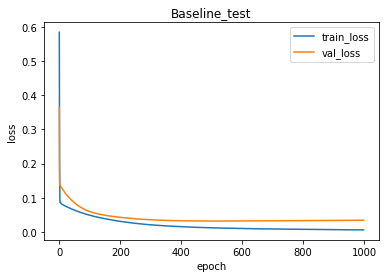

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.title('Baseline_test')
plt.savefig('../results/baseline_test/baseline_test_valloss.png')
plt.show()